 # 8-Queens-Problem++

# Initialization

In [1]:
# Leave the lines in this block intact
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

# Importing AIMA tools
# If you have not copied the contents of the template directly into the AIMA folder, you can uncomment the next line.
#sys.path.append(os.path.realpath("../aima-python")) # Modify the ./aima to the relative path of your aima folder.

# Do not change the rest of this block
import numpy as np

from utils import expr
from kb import DpllPropKB

import chessboards as maps
from ask_solution import ask_solution
from vis_utils import draw_chessboard, draw_tuples
from field_var import field_var, Queen, Pawn, Danger

KB = globals()["DpllPropKB"]

# Problem Description
In the [classical 8 queens problem](https://en.wikipedia.org/wiki/Eight_queens_puzzle), the goal is to place 8 queens on a 8x8 chessboard such that they can not strike each other. A queen can strike another queen, if they are both in the same row, column, or diagonal.

This exercise is based on this problem, but with several important modifications:
- The size of the board is **not necessarily 8x8, but can be 5x5, 6x6,...**
- We do **not focus our attention on finding the (theoretical) maximum number of queens** that can be placed on a board. This means, for example, that solutions with 7 queens on an empty 8x8 chessboard will also be considered as valid solutions, as long as no additional queen can be placed.
- In addition to the queens, there may also be pawns on the chessboard. **Pawns can 'block' the influence of a queen**, see below for more details.

You will be given several initial chessboards, with a few queens and pawns. Your task will be to fill the chessboard with new queens, until no new queen can be placed.

In order to produce such an algorithm, you should construct a knowledge base, with which one can infer which fields on the board cannot be occupied by a new queen. **Such fields will be called danger fields**.

The location of the next queen will always be chosen as follows:

_In the first row (starting from the top) where there is an empty field, choose the first column (starting from the left) that is empty; place the next Queen there._

You do **not** need to implement that part of the algorithm. Your task is only to set up a knowledge base that determines which fields are in danger.

## Passing the exercise
You will have passed the exercise if you can successfully solve all 8 scenarios that are given to you together with this template. Additionally, your code also has to solve 5 hidden scenarios, that are only available on Artemis.

If your implemented function computes the knowledge base such that every scenario is solved correctly (including the hidden ones), you successfully completed this programming exercise.

Your code has to compute a valid solution for each of the scenarios within 5 min on our machine. If your code takes longer to compute a solution, you will fail this submission. Don't worry about the computation time too much as usually the algorithm produces a solution within seconds for our specific exercise. Your submission will be evaluated after the deadline, but until then you can update your solution as many times as you like. The last submitted solution will be graded.


# Rules

To visualize the position of the queens, pawns, and danger fields, an $n\times n$ chessboard will be represented as a 2-dimensional numpy array ``chessboard[i][j]``. The $(i,j)$-th entry of this array corresponds to the $(i,j)$-th field on the chessboard, for $0\leq i,j\leq n-1$, where $(0,0)$ is in the upper left corner, $i$ indicates the column-number, while $j$ indicates the row-number. See also the image below, in the case of a 5x5 chessboard:

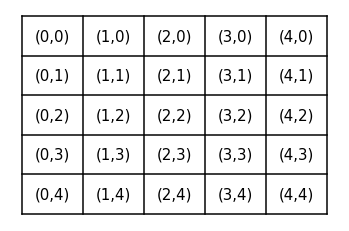

In [3]:
# You can change the chessboard size, if you want to see the field designations for larger chessboards
draw_tuples(board_size=5)

Each entry can have four different values:

- 0, which means that the field is **empty**
- 'Q', which means that the field has a **Queen**, which will be represented as <img style="vertical-align: -13px; display: inline;" width=40px src="img_notebook/queen.png">
- 'P', which means that the field has a **Pawn**, which will be represented as <img style="vertical-align: -13px; display: inline;" width=40px src="img_notebook/pawn.png">
- 'D', which means that the field is **in Danger**, which will be represented as <img style="vertical-align: -5px; display: inline;" width=30px src="img_notebook/trueDanger.png">

## Queens
Just like for regular chess, given an empty board with just one queen, any field that is in the same column, row, or diagonal as the queen is in danger. See also the example below:



<div>
<img src="img_notebook/queen_example.png" width="400"/>
</div>




## Pawns
Pawns are able to block the danger influence of queens, meaning that all tiles 'behind' a pawn are not in danger. A more practical formulation would be that _**any field on the same column, row, or diagonal as a queen is in danger, unless there is a pawn in between**_. The chessboard below illustrates this rule:


<div>
<img src="img_notebook/pawn_example.png" width="400"/>
</div>

# Visualization

In order to visualize the state of the chessboard, you can use one of the options demonstrated below:

In [4]:
# Set up a simple chessboard
chessboard_example = np.zeros((5, 5), dtype = object)
chessboard_example[4, 0] = 'Q'
chessboard_example[1, 1] = 'Q'
chessboard_example[0, 3] = 'P'

In [5]:
# You can print the entire array using the python print function:
# (Carefull, you need to 'transpose' the array first if you use print)
print('The chessboard array:\n', chessboard_example.T)

# A better way of printing the chessboard is given by this function:
def pretty_print(chessboard_array):
    for row in chessboard_array.T:
        print(str([str(element) for element in row]))
        
print('Pretty print of the chessboard:')
pretty_print(chessboard_example)

# You can access the array elements with chessboard_example[x][y]
print('The tile at position 1,1 is ', chessboard_example[1][1])
print('The tile at position 0,3 is ', chessboard_example[0][3])

The chessboard array:
 [[0 0 0 0 'Q']
 [0 'Q' 0 0 0]
 [0 0 0 0 0]
 ['P' 0 0 0 0]
 [0 0 0 0 0]]
Pretty print of the chessboard:
['0', '0', '0', '0', 'Q']
['0', 'Q', '0', '0', '0']
['0', '0', '0', '0', '0']
['P', '0', '0', '0', '0']
['0', '0', '0', '0', '0']
The tile at position 1,1 is  Q
The tile at position 0,3 is  P


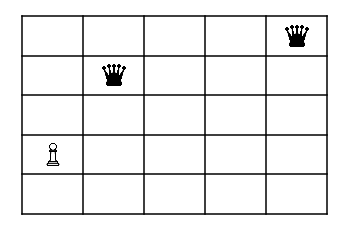

In [6]:
# A graphical representation of the chessboard can be produced by using the function draw_chessboard()
draw_chessboard(chessboard_example)

# Knowledge Base generation

## Atomic sentences

Your task is to implement the knowledge base that inferes for each field whether it is in danger. To represent the state of a field, use one of the three predicates for the Queen, Pawn, and Danger fields, as shown below:

In [7]:
# Formalization of the sentence 'There is a queen in field (1,2)':
Queen(1, 2)

'Q12'

In [8]:
# Formalization of the sentence 'There is a pawn in field (2,0)':
Pawn(2, 0)

'P20'

In [9]:
# Formalization of the sentence 'Field (3,3) is in danger':
Danger(3, 3)

'D33'

## Telling and asking the knowledge base

With the atomic sentences introduced above, you should contruct correct logical sentences that can be used to infer the new danger fields.

Below you will find examples detailling the notation you can use to construct such sentences, and how to add them to the knowledge base.

_**Note:**_ The next logical sentences are only meant to illustrate the notation, and do not necessarily reflect real scenarios.


In [10]:
# Notation you can use:
# &     Logical AND
# |     Logical OR
# ~     Negation
# ==>   Implication
# <==   Reverse Implication
# <=>   Equivalence
# (...) Parentheses

# Example of a simple knowledge base construction
# Create an empty knowledge base
kb = KB()

# Formalize the sentence 'There is a queen in the upper left corner':
sentence = Queen(0,0)
# Add this sentence to the KB 
kb.tell(expr(sentence))

# Formalize the sentence
#'There is no Queen in field (0,0) if and only if
# field (1,2) is in Danger or field (0,1) has a Pawn'
sentence = '~'+Queen(0,0)+'<=>'+'('+Danger(1,2)+'|'+Pawn(0,1)+')'
# Add this sentence to the KB
kb.tell(expr(sentence))

# Formalize the sentence 'If there is Danger if field (1,2),
# then there is a Pawn in field (0,1)'
sentence = Danger(1,2)+'==>'+Pawn(0,1)
kb.tell(expr(sentence))

# We can now 'ask' the knowledge base whether field (1,2)
# is *not* in danger:

kb.ask(expr('~'+Danger(1,2)))

True

### Important
If something is undefined in your knowledge base, or if the inference fails, ``kb.ask`` will always return ``False``. Therefore, make sure that you define your knowledge base properly.

The following example shows how an incorrectly defined knowledge base can lead to problems:

In [11]:
# Create a new, empty knowledge base:
kb = KB()

# Add the sentence 'If there is a Queen in field (0,0), then
# the field (1,1) is in danger'
sentence = Queen(0,0) + '==>' + Danger(1,1)
kb.tell(expr(sentence))

# If you do not add to the knowledge base the information
# that there is a Queen in (0,0), both of the following 
# return False:
print(kb.ask(expr(Danger(1,1))))
print(kb.ask(expr('~'+Danger(1,1))))

False
False


## Generating your knowledge base

For this exercise, you will only be required to generate the sentences to be added to the knowledge base. Here is what it could look like:

In [12]:
def generate_knowledge_example(chessboard_array):
    chessboard_size = len(chessboard_array)
    kb = []
    all_fields = [(x,y) for x in range(chessboard_size) for y in range(chessboard_size)]
    
    # Sets every field to danger:
    for field in all_fields:
        kb.append(Danger(field[0],field[1]))


    return kb

## Your Task

Implement the function ``generate_knowledge`` in ``generate_knowledge.py``. This is the only file you need to modify, and is the only file you need to submit.

The function ``generate_knowledge`` will only be called once at the start, before the main loop. It should setup the initial knowledge (i.e., where are the pawns, where are the initial queens, etc), as well as the rules governing the danger tiles.

Then, in each iteration of the main loop, the field for the next queen will be chosen. To do so, the new danger fields will be infered using your knowledge base. Then, the new field for the queen will be determined using the rules mentioned above. Once the new queen has been placed, the corresponding sentence is added to the knowledge base automatically (e.g., if a queen has been added on field (1,3), then 'Q13' will be added to the knowledge base). **You do not need to implement this part of the algorithm, you only need to implement the initial knowledge base.**

Feel free to define in ``generate_knowledge.py`` any helper function you may need, but do not import any additional modules or packages, otherwise your solution will be marked as failed. This exercise is easily solvable without any additional packages.

# Running the Algorithm



In [ ]:
# You can run this cell to test your implementation.
# Be aware that on some systems, if you modified generate_knowledge.py,
# you may need to restart the kernel of this notebook (click on the '>>' at the top)

# Select the initial chessboard by setting chessboard_index to a value between 1 and 8
chessboard_index = 1
chessboard = getattr(maps, "chessboard"+str(chessboard_index))

from generate_knowledge import generate_knowledge

# Create an empty knowledge base, and fill it with your knowledge base
kb = KB()
kb_init = generate_knowledge(chessboard)

print('Feeding the knowledge base with the expressions from generate_knowledge...')
for expression in kb_init:
    kb.tell(expr(expression))
print('Done.')

# Set up some helper variables
free_space = True
step = 1

while free_space:
    # While there still is some potential free space where one could place a queen...
    
    # Now, check for each empty whether it is in danger or not
    print("Computing the new danger fields. Please be patient...")
    chessboard = ask_solution(chessboard, kb, n=len(chessboard))
    print("Done.")
    
    # Display the results
    print("Results for step "+str(step)+":")
    step = step + 1
    draw_chessboard(np.array(chessboard))
    
    if step > 10:
        # If, in your solution, there are more than 10 queens to be added, you did a mistake somewhere.
        # In this case, the algorithm abandons, to avoid infinite loops.
        print("Failed to find a solution in finite time.")
        break
    
    # Now, select the uppermost, leftmost (in that order of priority) spot that
    # is not in danger, and place a queen there
    free_space = False
    for y in range(len(chessboard)):
        for x in range(len(chessboard)):
            if chessboard[x][y] == 0:
                chessboard[x][y] = 'Q'
                
                # If a queen was placed, add this to the knowledge base
                sentence = Queen(x,y)
                kb.tell(expr(sentence))
       
                free_space = True
                    
                break
        
        if free_space:
            break
    
